# Amazon Review - Machine Learning Project
Done as a final project for Udacity's machine learning nano degree. For more information, check our their [website](www.udacty.com).
 

## Project Overview
The quality of the comments made on internet forums has always suffered due to anonymity of it’s
users. When users comments on, for instance, a YouTube video, there is no repercussion for what they
say, and the dialog generated is often not helpful. Different websites have tried different methods for
extracting more useful comments. Reddit uses an up-vote system, Quora fosters a community that
values high quality responses over low quality ones, and Amazon allows for its users to to rate the
“helpfulness” of reviews left on their products. Amazon’s system, in particular, then allows for the
higher rated comments to be displayed at the top of the review forum so that new users can see the top
rated comments in order to help them make their own purchasing decisions.

Even though Amazon’s helpfulness rating system seems to work on the surface level, poor quality
comments still seem to be at the top of their review forms. Having poor quality reviews hurts Amazon’s
business, as a major reason that people are willing to buy consumer goods on-line without seeing the
items themselves, is that they have access to others peoples opinions of the item. For example, a review
at the top of an app called [“Friday Night at Freddies 4”](https://www.amazon.com/Five-Nights-at-Freddys-4/dp/B012J53LKY) is as follows:

>“I love this game so much but at first I though it was lame but when I go in the game I can't
beat the first night because cause I put it to full volume and I can't here the breathing
bonnie strike at 4 am Chica at 5 and plus it not lame it's better than fnaf and fnaf 2 plus get
this game when u buy fnaf”

This comment, despite being at the top of the forum, is difficult to understand, a run on sentence, and
full of spelling errors. The reason for the failure is part of the algorithm for determining the order of the
reviews relies on how recently the review has been made. The offending review was the most recent,
but it’s helpfulness score was far less than previous reviews. This illustrates the difficult balance that
must be struck between showing the highest rated reviews, and showing the newest reviews, to be rated
by the community. An ideal system would predict if a review is helpful or not, so that poor quality
reviews would not need to be displayed the top.

### Problem Statement

The problem being addressed in this project is the poor quality of Amazon reviews at the top of the
forum despite the “helpfulness” rating system. The problem arises from the “free pass” given to new
reviews to be placed at the top of the forum, for a chance to be rated by the community. The proposed
solution to this problem is to use machine learning techniques to design a system that “pre-rates” new
reviews on their “helpfulness” before they are given a position at the top of the forum. This way, poor
quality reviews will be more unlikely to be shown at the top of the forum, as they do not get the “freepass” because they are new. The proposed system will use a set of Amazon review data to train itself to
predict a helpfulness classification (helpful, or not helpful) for new input data.

The data used for this project is provided by the University of California, San Diego and is available at Julian McAuley's [research page](http://jmcauley.ucsd.edu/data/amazon/). See the references at the end of this project for more information. As the original set is massive, we will only look at a subset of the data: the reviews for [apps for Android](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz). 

### Metrics

Our problem is a binary classification problem (helpful or not helpful). We will use the ‘Receiver
Operator Characteristic Area Under the Curve’ or `roc_auc score` to evaluate our model. The ROC curve is a good way to visualize the performance of our binary classifier as it allows us to see the effect of changing the threshold for acceptance (or positive classification) of our classifier. A classifier often outputs a probability of a positive, i.e it is never quite 100% sure that the sample is positive, it could be 75% sure. When you use a classifier to predict the label of a sample, many models will threshold at 50%, outputting the prediction as positive if it is above 50% sure. If another metric is used, such as "misclassification rate", you can only observe the error rate for a single threshold, and thus you don't get the same amount of information. Another advantage to the ROC curve is that it is insensitive to unbalanced classes which, as we will see later in the analysis, is the case for our dataset.

The ROC curve also doubles as a method of providing a single number for the performance of the classifier by measuring the area under the curve (AUC). As the ROC curve is insensitive to unbalanced classes, by extension neither is the AUC score. 

The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR). The area under the curve is used to give a score to the model. If the area under the curve is 0.5, then the TPR is equal to the FPR, and the model is doing no better than random guessing. A perfect model would have an AUC of 1.0, meaning it has 100% TPR. For more information on the roc_auc score please visit the [sklearn page](http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics). This [YouTube video](https://www.youtube.com/watch?v=OAl6eAyP-yo&feature=youtu.be) is also fantastic explanation.

## Analysis

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import pandas as pd
import gzip
import seaborn as sns
import string
from time import time
import nltk
from urllib.request import urlretrieve
from nltk.corpus import stopwords 
stops = set(stopwords.words("english"))


from IPython.display import display # Allows the use of display() for DataFrames


import warnings
warnings.filterwarnings('ignore')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

# Lets define some helpful constants
DATASET_NAME = 'reviews_Apps_for_Android_5.json.gz'

# A size for figures
FIG_SIZE = (14,8)

#Random state for classifiers
RAN_STATE = 42


### Data Exploration

First we will check if we have already downloaded the dataset. If not, we will download it.

In [4]:
url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent
                
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

test = maybe_download(DATASET_NAME, 95509687)


Found and verified reviews_Apps_for_Android_5.json.gz


We need to extract the data, and convert the data given in "json" to a dataframe in order to perform our analysis. To save time for later we will pickle the file.

In [5]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    data = {}
    for d in parse(path):
        data[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

#removes extensions and adds pickle.
pickle_file_name = (DATASET_NAME[:-8]+'.pickle')

#loads pickle if exists, extracts and pickles if it doesn't
if os.path.exists(pickle_file_name):
    print ('Pickled file already present, loading...')
    data = pd.read_pickle(pickle_file_name)
    print ('Pickle file loaded.')
else:
    data = getDF(DATASET_NAME)
    data.to_pickle(pickle_file_name)



Pickled file already present, loading...
Pickle file loaded.


OK now lets have a look at the data.

In [6]:
data.head(1)

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]",1383350400,"Loves the song, so he really couldn't wait to ...",3.0,"11 2, 2013",Really cute


The `helpful` score can be explained as follows: a user can either rate the review as 'helpful’ or ‘not
helpful’. The dataset records each of these in an array. For our problem we want to classify the review as
either ‘helpful’ or not ‘helpful’. For training, this label can be generated by dividing the ‘helpful’
ratings by the total ratings and seeing if it exceeds a certain threshold.

Lets extract the information we need for this project:

* The 'reviewText' will be used to generate features using natural language processing.
* The score will be used as a feature in our final model. It will not be included in the benchmark model.
* The 'helpful' rating will be used to generate labels. We will train our model using these training labels. Predict the label using the test features, and measure the success of our model using the test labels. This will be explained more later.

Other features that could be important would be the summary; however, in the interest of keeping this simple, we will exclude it from the analysis.

In [7]:
#select the columns
df = data.iloc[:, [6,5,3]]

#split numerator and denominator
df['helpful_ratings'] = df['helpful'].apply(lambda x: x[0])
df['total_ratings'] = df['helpful'].apply(lambda x: x[1])

# delete un-needed 'helpful catagory
del df['helpful']

#Check if we have any null values
print (df.isnull().sum())


overall            0
reviewText         0
helpful_ratings    0
total_ratings      0
dtype: int64


Lets have a quick look at the stats..

In [8]:
df.describe()

,overall,helpful_ratings,total_ratings
count,752937.000000,752937.000000,752937.000000
mean,3.968931,3.435937,4.473125
std,1.342484,37.328951,43.688824
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,2.000000
max,5.000000,8116.000000,9258.000000


There are clearly some outliers and weird numbers in here. The max for both the helpful numerator and the denominator are both over 1000 standard deviations from the mean of the data. Lets move on to some visualization.

### Exploratory Visualization

Lets have a look at how our data is distributed.

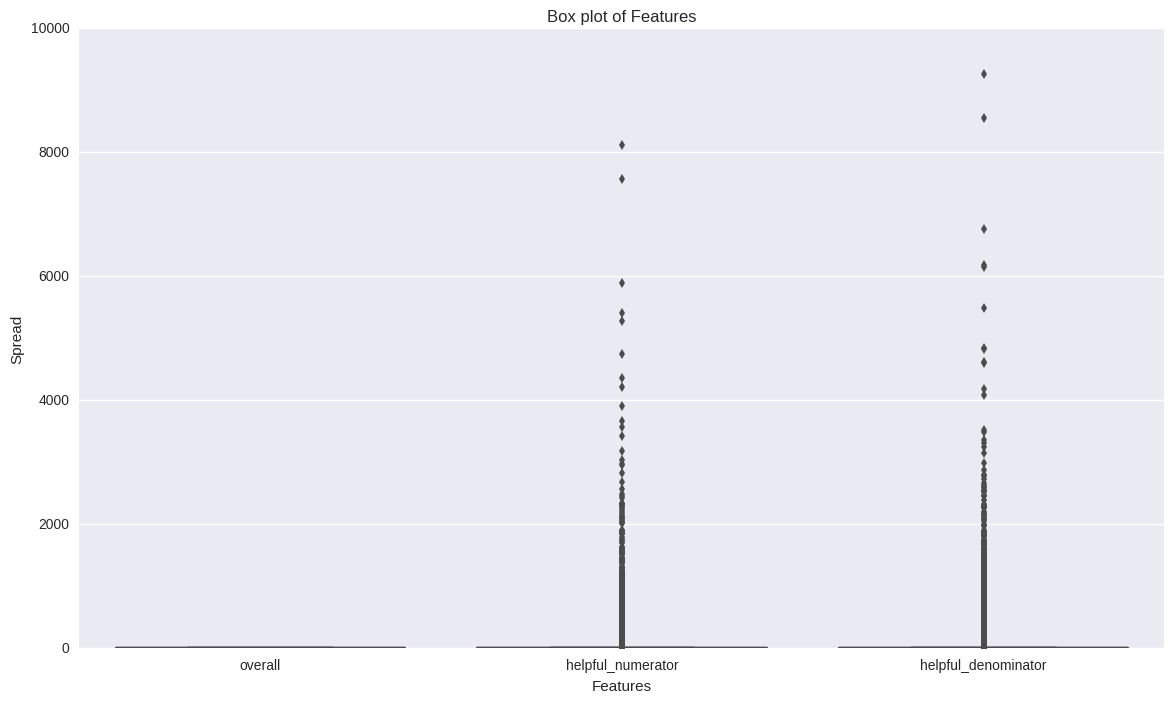

In [7]:
### Box Plot
plt.figure(figsize=FIG_SIZE)
plt.title('Box plot of Features')
plt.ylabel('Spread')
plt.xlabel('Features')

display(sns.boxplot(df[df.columns]))

As expected this is pretty ugly, let's have a look at a couple of the outliers and make sure they are valid data.

In [16]:
print (df['helpful_ratings'].idxmax(axis=0, skipna=True))
print (df['total_ratings'].idxmax(axis=0, skipna=True))

510127
510127


In [15]:
df.iloc[[510127,510128]]

,overall,reviewText,helpful_ratings,total_ratings
510127,5.0,This game is the perfect sequel to Temple Run....,8116,9258
510128,1.0,this was working fine now it won't even open.....,0,2


This reviewText looks fine to me. The amount in the helpful_ratings and total_ratings won't matter as we are going to transform these labels later on.

## Methodology

### Data Preprocessing


Data that has had less than 10 ratings will first be trimmed out of the dataset. There are a significant amount of reviews, and many do not face the scrutiny of people reading them. As many of these reviews could be good, but by chance, do not get read and rated, they will be rated negatively by our algorithm and will cause our model to incorrectly classify future "good" reviews.

In [18]:
#include reviews that have more than 10 helpfulness data point only
df1 = df[(df.total_ratings > 10)].copy()
df1.shape

(47932, 4)

In order to perform our analysis, we wish to determine if a given review text is helpful or not. We need a way to map the existing data to this binary classification. The chosen method is to use a threshold of 'helpful_ratings' divided by 'total_ratings'. In other words, the ratio of the people who found the review helpful over the amount of people who rated the review as helpful or unhelpful. If this ratio exceeds a certain threshold value, we can label the training data as 'helpful' = 1, or 'non-helpful' = 0. For this analysis, the threshold is arbitrarily set to 0.5, however, this could be tuned in the future to a higher value in order to better filter the reviews.

It is worth discussing the implications of getting rid of the 'helpful_ratings' and 'total_ratings'. Reviews rated as 50/100 and 5000/10000 are now treated equally. This is deemed to be ok as reviews with higher rating amount have been seen by more people often as a result of being at the top of the forum (a postitive feedback loop). The ratio of people that find it helpful is more important. This effect can disappear at small ratings (e.g 1/2) so the reviews with less than 10 ratings have been eliminated (as per above),

In [19]:
#transform Helpfulness into a binary variable with 0.50 ratio
threshold = 0.5
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'helpful_ratings'] \
                                 / df1.loc[:, 'total_ratings'] > threshold, 1, 0)
df1.head(3)

,overall,reviewText,helpful_ratings,total_ratings,Helpful
33,3.0,"I did the 7-day trial and was impressed, but a...",15,20,1
94,5.0,"This app is great! It has a daily verse, a da...",96,107,1
284,2.0,This app simply latches on to Google maps and ...,11,23,0


Now lets do a visualization and a count of the data in order to get a sense of the correlation and distribution.

In [20]:
#Check the balance
print ('Count:')
display(df1.groupby('Helpful').count())


Count:


,overall,reviewText,helpful_ratings,total_ratings
Helpful,,,,
0,6210,6210,6210,6210
1,41722,41722,41722,41722


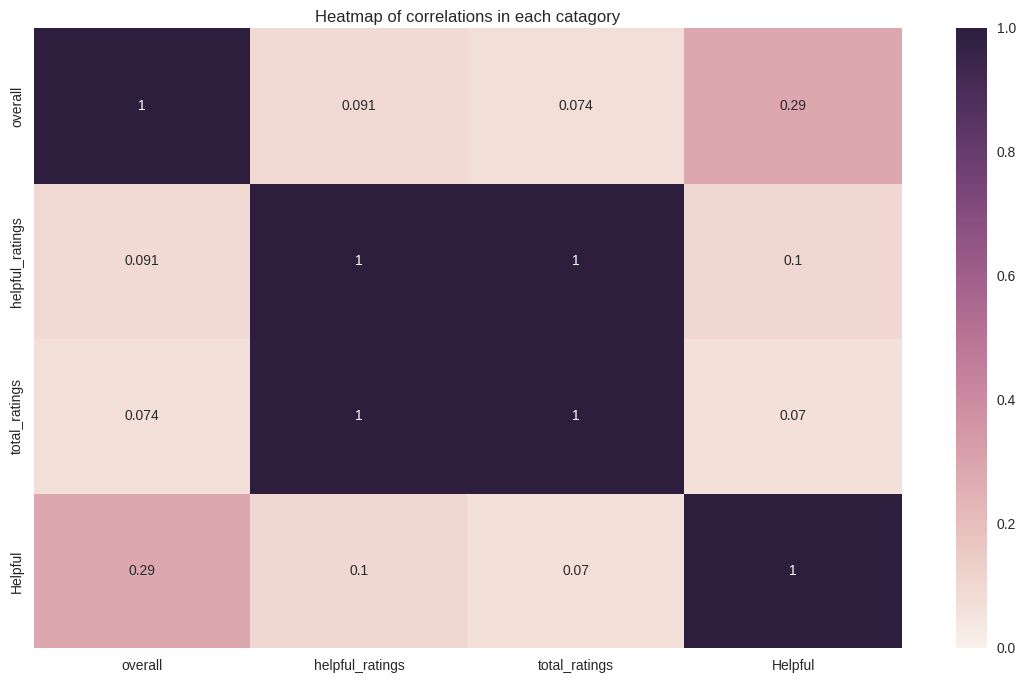

In [21]:
#Visualize correlation of the data
correlations = df1.corr()
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)


We can see that our dataset in unbalanced, with roughly 7 times as many effective reviews as ineffective reviews. This means that when we are splitting our data later, we will need to use a stratified shuffle so that both categories have proportional representation in training.

We can also see that there is a small correlation between the score and the 'Helpful' rating. It is good that this correlation is small, or else our job would be very easy and we wouldn't need to generate features from the reviewText at all, we could just look at the score of the review. 

### Text Feature Generation
Now lets convert the text to lower case so we can run our natural language processing to produce features. We will also remove punctuation. Removing punctuation may seem like it should not be done in the case of this problem, as not having punctuation will make a review harder to understand. This is a trade-off that we must consider. If we include punctuation, it will cause the learning algorithm to behave poorly.

In [22]:
# convert text to lowercase
df1.loc[:, 'reviewText'] = df1['reviewText'].str.lower()

def remove_punctuation(text):
    return text.translate(None, string.punctuation.translate(None, '"'))

df1['reviewText']=df1['reviewText'].apply( lambda x: remove_punctuation(x))
df1['reviewText'].head(4)

33     i did the 7day trial and was impressed but am ...
94     this app is great  it has a daily verse a dail...
284    this app simply latches on to google maps and ...
288    unable to move to sd card uninstalled cannot r...
Name: reviewText, dtype: object

In order to generate more features we will use the [TF-IDF vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from the sci-kit learn library. We will also use the [NLTK](http://www.nltk.org/) library. The pre-processing methods that we are going to employ are as follows:

* __Stemming__ - Stemming means to take off the suffixes of the stemmed word. Therefore words such as "run" and "running" would both be represented as "run". This allows for our algorithms to more accurate find trends in the "meanings" of sentences (e.g "the sun is shining" and "the sun shines" will more accurately be associated with the same meaning. It will reduce the total amount of features that we will generate.
* __Tolkenizing__- Splits sentences up into single words. This is needed to generate our TFIDF features.
* __Remove Stop Words__- This moves words such as "the" "a" and "it" as shown in the English stop words [corpus](http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words). These will only clutter up our learning algorithm. Admittingly, sentences without these words are hard to understand, and ideally they should be kept, but it is again a trade-off.
* __ngrams__- Makes groups of words that are 'n' long. E.g the 2-grams for the sentence "The shaggy dog" are [The, shaggy], [The, dog] and [shaggy, dog]. Weving more than that is computationally expensive for my computer. will stick to 2-grams and 1-grams for now. Having more than that is computationally expensive.

Finally we will generate Term Frequency-Inverse document Frequency ('TF-IDF') scores for each of the stemmed and tolkenized words and ngrams.  TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining. TF, or Term Frequency, measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization.

Inverse Document Frequency, or IDF measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones. This can be done using the following equation.

>TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

>IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

The TF-IDF weight is the product of these two numbers. For more information check out this [link.](http://www.tfidf.com/)

For our vectorizer, we will also set the min_df to 0.001. This is a cheap way of getting rid of spelling mistakes. Words that appear this infrequently are most likely typos and are uninteresting to our algorithm. It will also reduce our feature space, allowing for our algorithm to work faster.

In [33]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#create a stemmer
stemmer = SnowballStemmer("english")


#define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

#loads pickle if exists, extracts and pickles if it doesn't
if os.path.exists('features.pickle'):
    print ('Pickled file already present, loading...')
    features = pickle.load( open( "features.pickle", "rb" ) )
    print ('Pickle file loaded.')
else:
    #define the vectorizer
    vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
    #fit the vectorizers to the data.
    features = vectorizer.fit_transform(df1['reviewText'])
features

Pickled file already present, loading...
Pickle file loaded.


<47932x445 sparse matrix of type '<type 'numpy.float64'>'
	with 725739 stored elements in Compressed Sparse Row format>

We have now generated all of the features that we are going to need. 


## Benchmark Model

A model that is quick and often used for text classification is GaussianNB, We will use this as quick way to get a benchmark ROC_AUC score for the project.

For this purpose, we will split the data into 80% training and 20% testing. The benefit to splitting the data into testing and training sets is that this allows simulated evaluation of how well the model is performing before using it in the real world to make predictions.If there was no testing set, there would be no way of realistically evaluating the model as you would only be able to measure it's performace on data to which it's already been exposed. This will result in a false sense of confidence in how well the model performs.

### Function Setup
The code below initializes some helper functions used to test the models later.

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    probas = clf.predict_proba(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("ROC_AUC score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

Now lets train and predict using our benchmark model.

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

#split into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(features ,df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

#densify sparse matricies
x_tr = X_train.toarray()
x_te = X_test.toarray()

#train and predict.
# train_predict(gnb, x_tr, y_train, x_te, y_test)

Training a GaussianNB using a training set size of 38345. . .
Trained model in 1.3603 seconds
Made predictions in 1.5061 seconds.
ROC_AUC score for training set: 0.7156.
Made predictions in 0.2275 seconds.
ROC_AUC score for test set: 0.6770.



A ROC_AUC score is not that great, we should be able to improve this benchmark.

## Preliminary model selection

In order to select a final model for the project, we will look at all of the out of box models from sklearn.

The following algorithms were investigated:

- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbours (Neighbours)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

Information on each algorithm can be found at [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html). 

Taking this documentation into consideration, the following three algorithms have been selected to be investigated, for reasons listed below:

__Logistic Regression__: Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier.

* _Real World Application_: Logistic Regression is used frequently for text classification, and is popular in Kaggle competitions as a baseline classifier.
* _Strengths of Model_: Logistic regression can be updated after is has already been trained, meaning that new reviews can be used to teach the algorithm after it has already been training. 
* _Weaknesses of Model_: Logistic regression is not as fast as the naive bayes methods, but then again, not many algorithms are.
* _Selection Justification_: The ability to update itself after its initial training period may prove to be valuable.

__Random Forest__: A Random Forest is a ensembling algorithm that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. It does not implement boosting on the trees, and instead counts a vote of each individual tree in order to produce the final class label.
* _Real World Application_: Random Forest has been used in Diabetic Retinopathy classification analyses (5), and is very popular for Kaggle competitions.
* _Strengths of Model_: The strength of the Random Forest classifier comes from the formation of it's trees. Because it is formed from "random" subsets of the data, and the final result is compared to other trees that have also been formed "randomly", the algorithm guards well against "overfitting" from noisy data points that may have more influence on a single decision tree algorithm. The "random" formation of the trees ensures that there is little chance for a strong bias to be present in the data during tree construction. (4) Random Forests also work well with high dimensional data, as in the case of our TFIDF features.(5).
* _Weaknesses of Model_: A lot of trees are necessary to get stable estimates of variable importance and proximity. This can lead to a large amount of space in memory being needed to store the trees. Additionally, the trees need to be re-trained when new data is being introduced, unlike Naive Bayes. Its training complexity is given as O(M √d n log n) where d is the number of features and M is the number of trees. 
* _Selection Justification_: Since random forest works well with high dimensional data, as is competitive with other algorithms such as SVM without the high training cost (5) it is selected for our study.

__Adaboost__: AdaBoost or "adaptive boosting" begins by fitting a "weak" classifier on the original dataset. It then fits additional copies of the classifier on the same dataset and adjusts the weights of incorrectly classified instances such that subsequent classifiers focus more on difficult cases. The adjustment is done using the SAMME-R algorithm (for classification)
* _Real World Application_: Adaboost has been used in robust real time face detection (6). It is also quite popular for Kaggle competitions.
* _Strengths of Model_: Because of it's boosting property, Adaboost will not suffer from overfitting caused by too many training periods in the boosting algorithm. Theoretically, the algorithm should produce better and better results the more it is trained.
* _Weaknesses of Model_: Adaboost is slow to train, relative to GaussianNB (actual training complexity could not be found). 
* _Selection Justification_: It will be interesting to measure the performance of the boosting method of Adaboost vs the vote method for the RF algorithm, as both use decision trees and differ only in the method in which the tree are ensembled together for the final classification.


We will now test our classifiers using the functions above. All of the classifiers from sklearn will be tested, but only the three top choices discussed will have the results recorded in a table. We will train and test a bunch of the classifiers on three different training sizes in order to find which one will be our benchmark.

In [37]:
# Import the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Initialize the models using a random state were applicable.
clf_list = [GaussianNB(), 
            AdaBoostClassifier(random_state = RAN_STATE), 
            RandomForestClassifier(random_state = RAN_STATE), 
            LogisticRegression(random_state = RAN_STATE),
            DecisionTreeClassifier(random_state = RAN_STATE)]



# Set up the training set sizes for 100, 200 and 300 respectively.
train_feature_list = [x_tr[0:10000],x_tr[0:20000],x_tr]
train_target_list = [y_train[0:10000], y_train[0:20000], y_train]


# Execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, x_te, y_test)



Training a GaussianNB using a training set size of 10000. . .
Trained model in 0.2779 seconds
Made predictions in 0.2980 seconds.
ROC_AUC score for training set: 0.7553.
Made predictions in 0.2633 seconds.
ROC_AUC score for test set: 0.6507.

Training a GaussianNB using a training set size of 20000. . .
Trained model in 0.5831 seconds
Made predictions in 0.6269 seconds.
ROC_AUC score for training set: 0.7314.
Made predictions in 0.3906 seconds.
ROC_AUC score for test set: 0.6749.

Training a GaussianNB using a training set size of 38345. . .
Trained model in 0.9923 seconds
Made predictions in 1.0164 seconds.
ROC_AUC score for training set: 0.7156.
Made predictions in 0.3098 seconds.
ROC_AUC score for test set: 0.6770.

Training a AdaBoostClassifier using a training set size of 10000. . .
Trained model in 6.9275 seconds
Made predictions in 0.3750 seconds.
ROC_AUC score for training set: 0.7603.
Made predictions in 0.3705 seconds.
ROC_AUC score for test set: 0.6856.

Training a AdaBoostC

It seems that the Logistic Regression classifier did the best in our benchmark test. It's interesting to compare the speed of the Logistic Regression to the other algorithms. It is quite a bit faster than all of the algorithms, and more accurate than each of them for a test size of 38,000. In order to make sure we are covering all of our bases, we should also do a visualization.

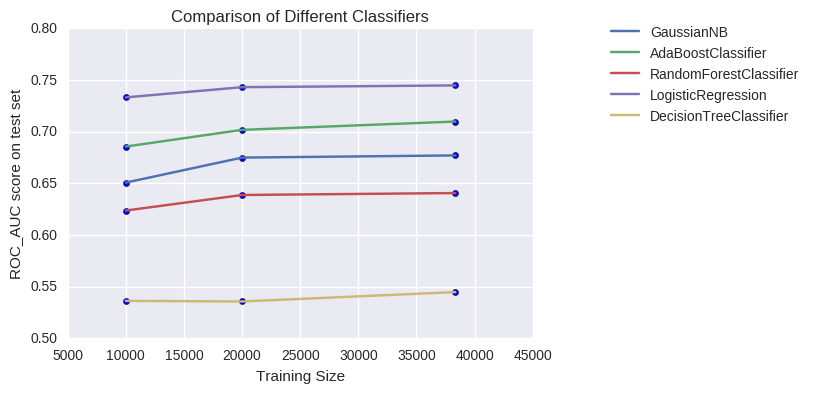

In [38]:
### Visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, x_te, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show()

As expected, the Logistic Regression is the best algorithm in terms of accuracy for all test sizes. It's final score for the area under the ROC curve was 0.7448 and a sample size of ~38,000. In addition it is the fastest. The training speed and prediction speed were 0.538s and 0.0137s respectively for a sample size of 38,000. As our system needs to consider the trade off between accuracy and speed, the Logistic Regression algorithm represents the ideal model for our benchmark. Surprisingly, the Random Forest algorithm did quite poorly in our tests. It was both slower and less accurate than the Naive Bayes algorithm. 

## Refinement

In order to improve our results we are going to try adding a new feature to our feature set. The 'overall' score category was shown before to have a correlation with 'helpful' or 0.29. Lets try adding it to the feature set and seeing how well the algorithm performs.

In [39]:
#add Score column to features
import scipy as scipy

features = pickle.load( open( "features.pickle", "rb" ) )
overall = np.array(list(df1.overall))
overall = overall.reshape(features.shape[0], 1)

features = scipy.sparse.hstack((features,scipy.sparse.csr_matrix(overall)))

features = scipy.sparse.csr_matrix(features)
features

<47932x446 sparse matrix of type '<type 'numpy.float64'>'
	with 773671 stored elements in Compressed Sparse Row format>

We can now split the dataset and try to optimize our benchmark model.

In [40]:
X_train2, X_test2, y_train, y_test = train_test_split(features, df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

### Grid Search

The grid search technique works by generating a grid of all possible provided parameter combinations. It then evaluates a model using a validation set based on every combination of parameters in the grid. It is used to find the optimum set of parameters for a learning algorithm given a data set.

### Cross-Validation
The k-folds validation training technique creates multiple testing and training sets and trains a model on each, averaging the results. The splitting method is to divide the data into separate bins (for example k = 5), train on bins 1 to k-1 and test on bin k. The next fold trains on bins 2 to k and tests on bin 1 and so on, until all of the bins have acted as a test bin. This effectively trains and tests the models on all of the data without over-fitting to the data.

The benefits that this provides for grid search while optimizing the model is that there is less of a chance that the final model won't be optimized to data that could potentially have a bias. For example, if somehow, all of the training data didn't contain a unique data point (such as a high MEDV value for a low RM) the final model would be very biased not predict this scenario, and the optimization will make that worse. However, with k-folds validation, one of the trained models will see the unique data point and the result will be reflected in the final averaged model.

In [41]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
#make the grid search object
gs = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**i for i in range(-5,5)], 'class_weight': [None, 'balanced']},
    cv=StratifiedKFold(y_train,n_folds=5),
    scoring='roc_auc'
)

#fit the grid search object to our new dataset
print ('Fitting grid search...')
gs.fit(X_train2, y_train)
print ("Grid search fitted.")

Fitting grid search...
Grid search fitted.


In [42]:
#print the grid search scores.
print (gs.best_estimator_)
gs.grid_scores_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


[mean: 0.73444, std: 0.01040, params: {'C': 1e-05, 'class_weight': None},
 mean: 0.73900, std: 0.00996, params: {'C': 1e-05, 'class_weight': 'balanced'},
 mean: 0.73978, std: 0.01059, params: {'C': 0.0001, 'class_weight': None},
 mean: 0.73457, std: 0.00989, params: {'C': 0.0001, 'class_weight': 'balanced'},
 mean: 0.75085, std: 0.01134, params: {'C': 0.001, 'class_weight': None},
 mean: 0.74382, std: 0.01042, params: {'C': 0.001, 'class_weight': 'balanced'},
 mean: 0.75392, std: 0.01162, params: {'C': 0.01, 'class_weight': None},
 mean: 0.75708, std: 0.01078, params: {'C': 0.01, 'class_weight': 'balanced'},
 mean: 0.77314, std: 0.01160, params: {'C': 0.1, 'class_weight': None},
 mean: 0.77892, std: 0.01072, params: {'C': 0.1, 'class_weight': 'balanced'},
 mean: 0.77960, std: 0.01075, params: {'C': 1, 'class_weight': None},
 mean: 0.77852, std: 0.01003, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.77717, std: 0.01043, params: {'C': 10, 'class_weight': None},
 mean: 0.77642, s

We can see the our optimized classifier is a LogisticRession with a 'C' parameter of 1 and a 'class_weight' = 'balanced'. This is the same as the default, meaning our optimization step did not actually change the parameters of the our of box model. We can now perform a prediction and measure it's results using a Radio Operator Curve visualization.

ROC_AUC Score: 0.779451374698


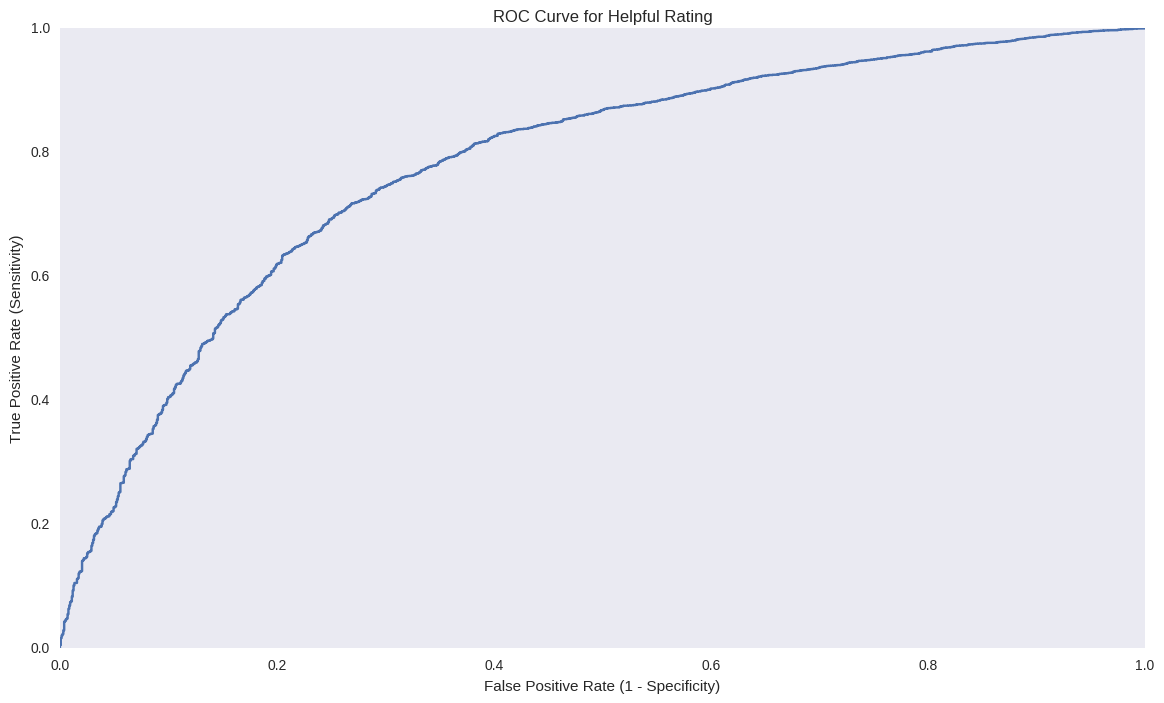

In [45]:
clf2 = gs.best_estimator_
probas =clf2.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))

In order to cover our bases, we will also perform a grid search cross-validation for the second best model:

Fitting grid search...
Grid search fitted.
ROC_AUC Score: 0.764437488067


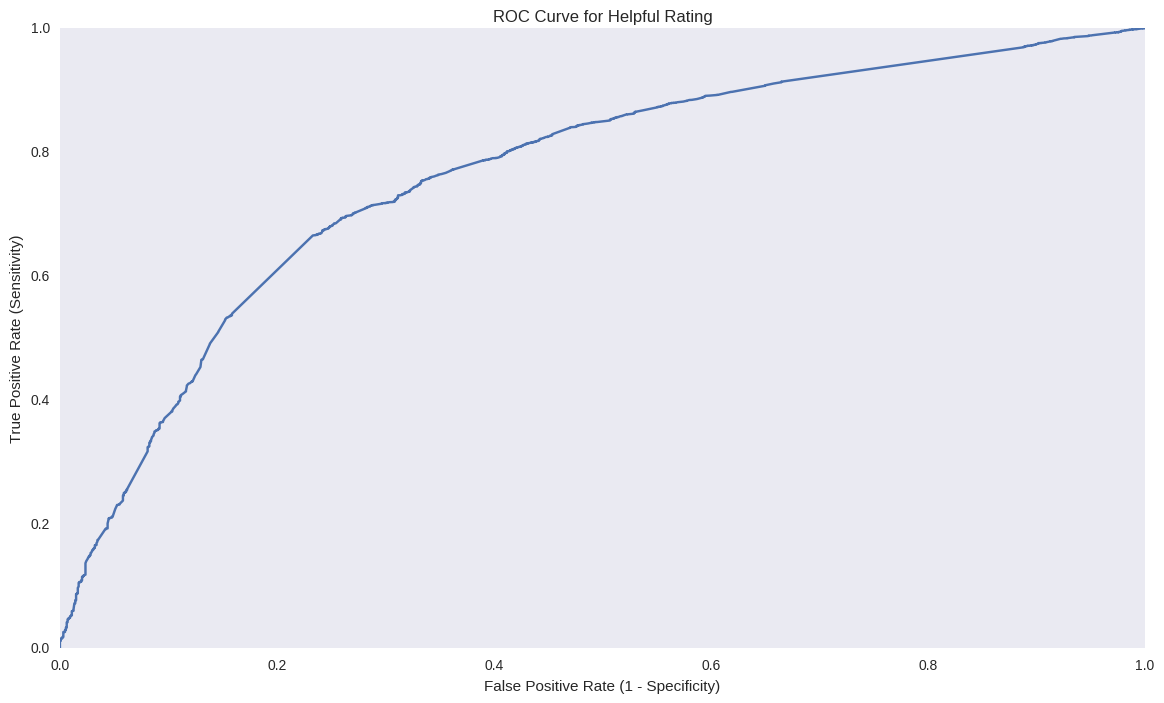

In [48]:
#make the grid search object
gs2 = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid = {'n_estimators' : [30, 50, 70, 80],
                  'algorithm': ['SAMME'],
                  'learning_rate': [0.001, 0.01, .80, 1.0]},
    cv=StratifiedKFold(y_train,n_folds=5),
    scoring='roc_auc'
)

#fit the grid search object to our new dataset
print ('Fitting grid search...')
gs2.fit(X_train2, y_train)
print ("Grid search fitted.")


ada = gs2.best_estimator_
probas =ada.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))

In [49]:
ada

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.8,
          n_estimators=80, random_state=None)

## Results

### Model Evaluation and Validation

There are several variables that we can examine in order to determine the robustness of our solution. Our feature space size was significantly reduced by setting the min_df (minimum document frequency) to 0.01, meaning that the terms needed to appear in the documents at least 1 percent of the time. This was done as an effort to eliminate spelling errors, but it also may have eliminated important words. I won't look into changing this, as increasing the amount of features is beyond the computational capabilities of my laptop.

Another variable that could be examined is the random_state variable of the Logistic Regression algorithm itself. The random_state variable for the Logistic Regression algorithm controls the seed of the pseudo random number generator to use when shuffling the data. If this number is changed and the auc_roc score of our classifier changes significantly, that could speak to the robustness of our solution.

In [25]:
random_numbers = range(1,101)
tot = 0.0
for seed in random_numbers:
    clf3 = LogisticRegression(random_state=seed)
    clf3.fit(X_train2, y_train)
    probas =clf3.predict_proba(X_test2)
    tot += roc_auc_score(y_test, probas[:,1].T)
    
print ('Average ROC_AUC Score for 1-100 random_state: {:.4f}'.format(tot/100))

Average ROC_AUC Score for 1-100 random_state: 0.7795


The average ROC_AUC score for 100 different random_states is equal to 0.7795, the same as our optimum solution. In this regard, our solution can be considered robust.

### Justification

Our final model using the 'overall' score and TFIDF features was able to score a value of 0.778 for the area under the ROC curve. Compared to the benchmark model scoring 0.742, this is a 3.6% improvement. As this was only the addition of one feature, and as our gridsearch showed, not a result of any other optimization, this can be considered significant. The area under the AUC_ROC can be directly interpreted as accuracy.

Our goal in the beginning of this project was to design a system to automatically classify new Reviews made on amazon products as 'helpful' or 'non-helpful'. Our optimum model will correctly do this 77.8% of the time. This means that 22.2% of the time, our system will not work. As someone managing this project, I would not be happy with this result and would seek to improve it.

Our algorithm is able to make predictions on the order of 0.01s per prediction. As this was done on my 8 year old laptop it is reasonable to assume that this could be improved significantly with better hardware. Further analysis that takes into account how many reviews are expected to be made would need to take place before I could determine if this is considered reasonable for this project.

## Conclusion

### Free-Form Visualization

A important quality of this project is the effect of introducing a new key feature to a benchmark model. Mainly, we looked at the TFIDF features generated from amazon review text and added the 'overall_rating' that was given to the product by the reviewer. We used these features to predict how 'helpful' other users would find the review. Our results can be visualized as follows:

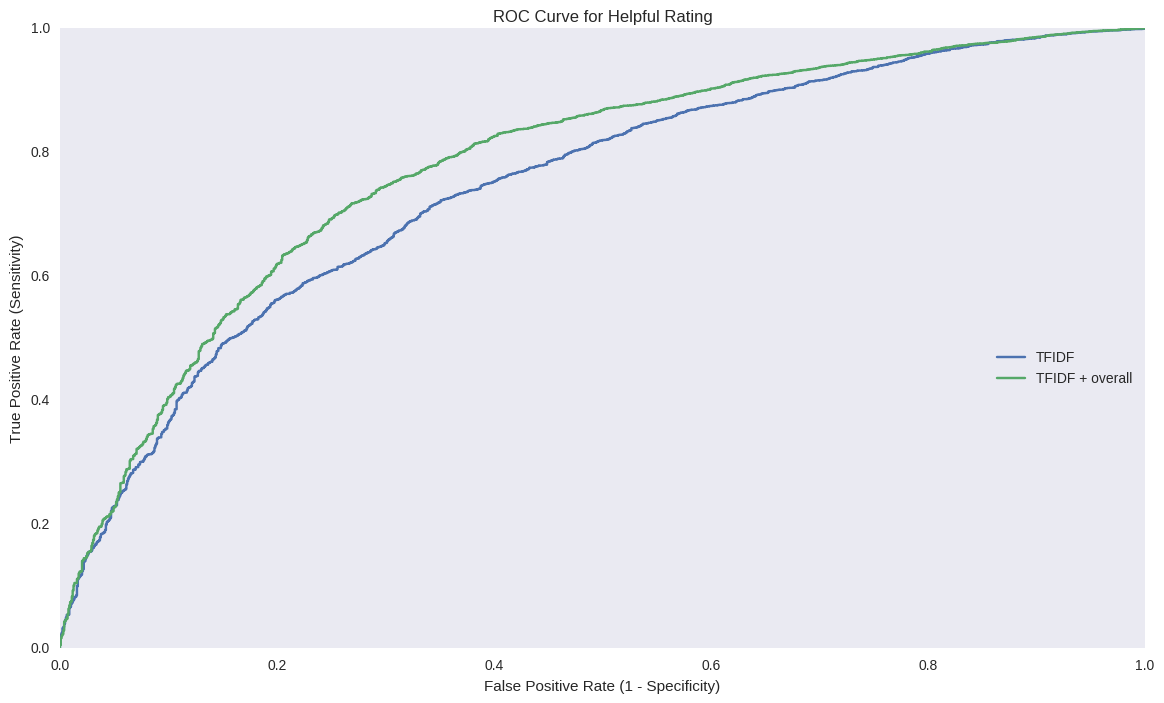

In [26]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
probas = clf.predict_proba(X_test)
clf2 = gs2.best_estimator_
probas2 =clf2.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)

plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label = 'TFIDF')
plt.plot(roc_curve(y_test, probas2[:,1])[0], roc_curve(y_test, probas2[:,1])[1], label = 'TFIDF + overall')
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.legend(bbox_to_anchor=(1.0, .5))
plt.figure(figsize=FIG_SIZE) 
plt.show()

Clearly seen in the ROC curve is the result of adding the 'overall' score to the feature set. The Area under the curve for the features set of TFIDF features plus to 'overall' score is notably higher.

### Improvements

In order to improve the accuracy of our model, the following actions could be taken:
 
* Perform more feature engineering, such as proper spell checking for the reviews. This would result in a model that potentially has less features, as certain spelling errors would have been corrected/eliminated.
* Explore the effect of not doing pre-processing on the reviews. Reviews with poor grammar, and punctuation and improper word endings are more difficult to understand and would possibly lead to people rating them as less helpful. During our project, we did this pre-processing in order to make the algorithms work better; however, maybe feature reduction should have been done in a different way to order to preserve the "incorrect" information.


### Reflection

A summary of the problem solution is as follows: Our model takes in existing 'reviewText' and transforms it into numerical TF-IDF scores. It then adds the existing 'overall' score of the reviews to create a features set for each review. It trains a Logistic Regression model using labels generated by taking existing 'helpfulness_numerator' data and dividing it by 'helpfulness_denominator' data and thresholding the result at 0.5. It then takes in new reviews with no helpfulness data from user ratings and attempts to classify them as being 'helpful' or 'non-helpful'. By using this system, Amazon can work to make sure than more 'helpful' reviews are shown at the top of their forums. 

This project is interesting in the sense that it is not like typical text classification problems. In many text classification problems, you are trying to reduce the dimensionality of text data as much as possible by combining synonyms, stemming words, and correcting spelling mistakes. However, in the context of this problem, that may have not been desirable as then main reason that people may have found a review unhelpful is because of these imperfections. It would be interesting to explore this problem again, without doing some of these preprocessing steps.

Another interesting thing to try would be to extract the most 'useful' words from the TF-IDF feature set. This could be done using the `.vocabulary_` attribute from the TF-IDF vectorizer and the `feature_importance_` attribute from the `LogisticRegression()` classifier. The result of this analysis could be used to generate Review Guide to help new reviewers write better reviews.


## References

1. Inferring networks of substitutable and complementary products. J. McAuley, R. Pandey, J.
Leskovec Knowledge Discovery and Data Mining, 2015.
2. Image-based recommendations on styles and substitutes J. McAuley, C. Targett, J. Shi, A. van
den Hengel SIGIR, 2015.
3. HUI BWU Y. Anti-spam model based on semi-Naive Bayesian classification model. Journal of Computer Applications. 2009;29(3):903-904.

4. Liaw A. Weiner M. Classification and Regression by randomForest. R News. 2002;Vol 2(2):18-22.

5. Casanova R, Saldana S, Chew EY, Danis RP, Greven CM, et al. (2014) Application of Random Forests Methods to  Diabetic Retinopathy Classification Analyses. PLoS ONE 9(6): e98587. doi: 10.1371/journal.pone.0098587

6. Jones M. Viola A. Robust Real-Time Face Detection. International Journal of Computer Vision. 2004. pg 137–154.
7. http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/

